In [1]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt


/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [50]:
alpha_beta_df = pd.read_csv("/home/jjia/data/dataset/lung_function/alpha_beta_summary.csv")
pft_fpath = '/home/jjia/data/dataset/lung_function/SScBaseline_PFT_anonymized_with_percent.xlsx'  # id from 0068800 to 99..., total 333 cases
label_excel = pd.read_excel(pft_fpath, engine='openpyxl')
label_excel = label_excel.sort_values(by=['subjectID'])
new_df = pd.concat([label_excel, alpha_beta_df], axis=1)


In [51]:
alpha_beta_df.dtypes

pat_id      int64
alpha     float64
beta      float64
dtype: object

In [52]:
alpha_beta_df.columns

Index(['pat_id', 'alpha', 'beta'], dtype='object')

In [57]:
def merge(alpha_beta_df, label_excel, exclude_patid=False):
    if exclude_patid:
        df_new = pd.DataFrame(columns=['alpha','beta', 'DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])
        i = 0
        for idx, row in label_excel.iterrows():
            id = int(row['subjectID'].split('SSc_patient_')[-1][:7])
            row_ab = alpha_beta_df[alpha_beta_df['pat_id']==id]
            df_new.loc[i] = [row_ab['alpha'].iloc[0], row_ab['beta'].iloc[0],  row['DLCOc_SB'], row['FEV1'], row['FVC'], row['TLC_He'], row['DLCOcPP'], row['FEV1PP'], row['FVCPP'], row['TLCPP']]
            i += 1
    else:
        df_new = pd.DataFrame(columns=['PatID', 'alpha','beta', 'DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])
        i = 0
        for idx, row in label_excel.iterrows():
            id = int(row['subjectID'].split('SSc_patient_')[-1][:7])
            row_ab = alpha_beta_df[alpha_beta_df['pat_id']==id]
            df_new.loc[i] = [id, row_ab['alpha'].iloc[0], row_ab['beta'].iloc[0],  row['DLCOc_SB'], row['FEV1'], row['FVC'], row['TLC_He'], row['DLCOcPP'], row['FEV1PP'], row['FVCPP'], row['TLCPP']]
            i += 1
    return df_new

In [63]:
df_new = merge(alpha_beta_df, label_excel)
for name in df_new.columns:
    if name!='PatID':
        df_new[name].replace('', np.nan, inplace=True)  # exclude 3 rows with NV or empty cells
        df_new[name].replace('NV', np.nan, inplace=True)

        df_new.dropna(subset=[name], inplace=True)
        df_new[name] = df_new[name].astype(float)
    else:
        df_new[name] = df_new[name].astype(str)

In [64]:
df_new

,PatID,alpha,beta,DLCOc,FEV1,FVC,TLC,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,68800.0,-1.0730,9.5845,7.102,3.491,4.363,6.261,83.0,111.0,108.0,95.0
1,127512.0,-1.0994,9.3001,3.943,1.575,2.076,3.864,68.0,87.0,88.0,87.0
2,139552.0,-1.4488,10.4260,5.273,2.626,3.544,5.781,73.0,112.0,115.0,105.0
3,143788.0,-1.3389,10.9858,1.240,2.260,2.860,3.970,17.0,89.0,87.0,71.0
4,152440.0,-1.5033,10.1955,7.102,2.402,2.994,4.525,110.0,104.0,101.0,93.0
...,...,...,...,...,...,...,...,...,...,...,...
328,9523013.0,-1.4441,10.7688,6.741,3.492,4.117,5.214,60.0,82.0,80.0,66.0
329,9662556.0,-1.7964,11.0830,6.551,3.666,4.340,5.188,78.0,102.0,102.0,90.0
330,9861781.0,-1.1365,10.2187,5.380,3.870,4.900,6.120,56.0,100.0,100.0,86.0
331,9934096.0,-1.3998,10.0091,4.800,2.057,2.706,4.673,79.0,99.0,102.0,101.0


In [61]:
df_new.corr(method='spearman')

,alpha,beta,DLCOc,FEV1,FVC,TLC,DLCOcPP,FEV1PP,FVCPP,TLCPP
alpha,1.000000,-0.785151,0.094803,0.074422,0.084401,0.053343,0.095956,0.055848,0.100386,0.134950
beta,-0.785151,1.000000,-0.060421,0.058176,0.094140,0.158795,-0.174725,-0.055118,-0.056638,-0.072311
DLCOc,0.094803,-0.060421,1.000000,0.785819,0.750475,0.663564,0.879093,0.478602,0.444203,0.459911
FEV1,0.074422,0.058176,0.785819,1.000000,0.933365,0.778472,0.551057,0.604039,0.526323,0.460319
FVC,0.084401,0.094140,0.750475,0.933365,1.000000,0.894290,0.537566,0.606766,0.663491,0.608761
TLC,0.053343,0.158795,0.663564,0.778472,0.894290,1.000000,0.468422,0.539209,0.632546,0.747349
DLCOcPP,0.095956,-0.174725,0.879093,0.551057,0.537566,0.468422,1.000000,0.594678,0.567820,0.548600
FEV1PP,0.055848,-0.055118,0.478602,0.604039,0.606766,0.539209,0.594678,1.000000,0.897547,0.712226
FVCPP,0.100386,-0.056638,0.444203,0.526323,0.663491,0.632546,0.567820,0.897547,1.000000,0.843275
TLCPP,0.134950,-0.072311,0.459911,0.460319,0.608761,0.747349,0.548600,0.712226,0.843275,1.000000


<AxesSubplot: >

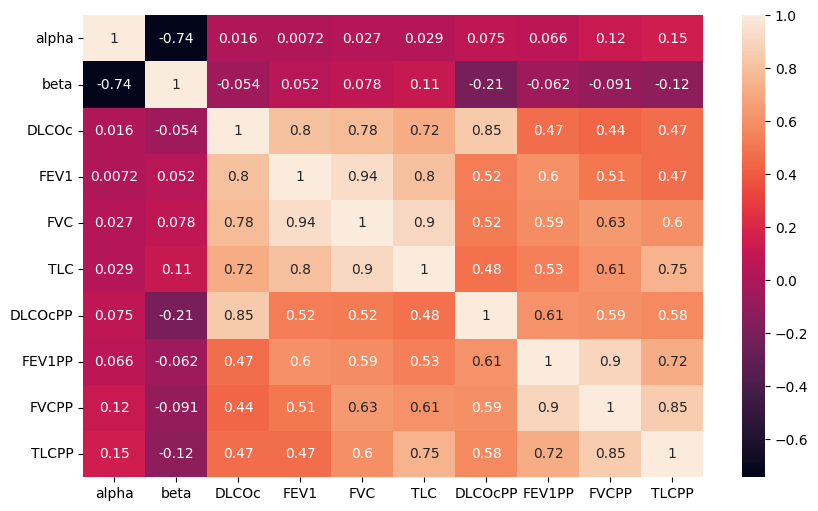

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_new.corr(), ax=ax, annot=True)

In [69]:
ts_pat_ids = ['9071115', '6503304', '6587088', '7852072', '0911478', '5112278', '9075756', '4125990',
                '0584534', '4945176', '3034278', '2712128', '1043946', '9934096', '5240010', '7135410',
                '7421048', '9367440', '5576984', '0152440', '3154090', '1160750', '6484444', '1105441',
                '4628660', '4171220', '1146160', '2131790', '0163750', '2151769', '5174713', '8365740',
                '2524918', '9239682', '3243752', '2341332', '7234834', '9160660', '5262908', '2253442',
                '0992750', '3567342', '5271048', '8278747', '9662556', '0222357', '8229975', '0139552',
                '3901150', '9300979', '0298877', '3228438', '8960279', '4107789', '7740702', '7252792',
                '8303176', '8492153', '5299407', '7957098', '1499510', '5323286', '5325396', '3310402',
                '5813928', '6122288', '0315573', '2346390', '5869896', '0280727', '5352138', '8353193',
                '5321814', '6329587', '1397732', '0458234', '9241693']


In [82]:
df_healthy = pd.DataFrame(columns=['PatID', 'alpha','beta', 'DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])
i = 0
for idx, row in label_excel.iterrows():
    id_str = row['subjectID'].split('SSc_patient_')[-1][:7]
    if id_str in ts_pat_ids:
        row_ab = alpha_beta_df[alpha_beta_df['pat_id']==int(id_str)]
        df_healthy.loc[i] = [id_str, row_ab['alpha'].iloc[0], row_ab['beta'].iloc[0],  row['DLCOc_SB'], row['FEV1'], row['FVC'], row['TLC_He'], row['DLCOcPP'], row['FEV1PP'], row['FVCPP'], row['TLCPP']]
        i += 1
        

In [81]:
def clean_nan(df):
    for name in df.columns:
        if name!='PatID':
            df[name].replace('', np.nan, inplace=True)  # exclude 3 rows with NV or empty cells
            df[name].replace('NV', np.nan, inplace=True)
            df.dropna(subset=[name], inplace=True)
            df[name] = df[name].astype(float)
    return df

In [86]:
df_healthy.to_csv('/home/jjia/data/dataset/lung_function/data77_jingnan.csv')

<AxesSubplot: >

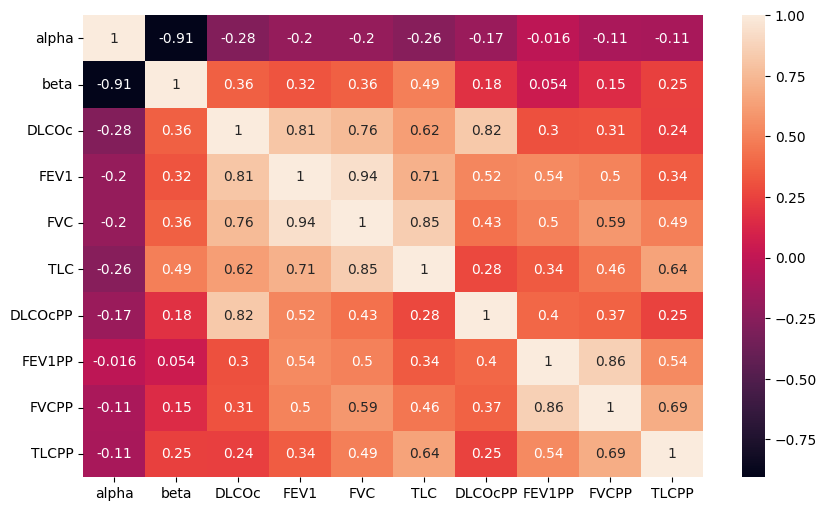

In [83]:
df_healthy = clean_nan(df_healthy)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_healthy.corr(method='spearman'), ax=ax, annot=True)

<AxesSubplot: >

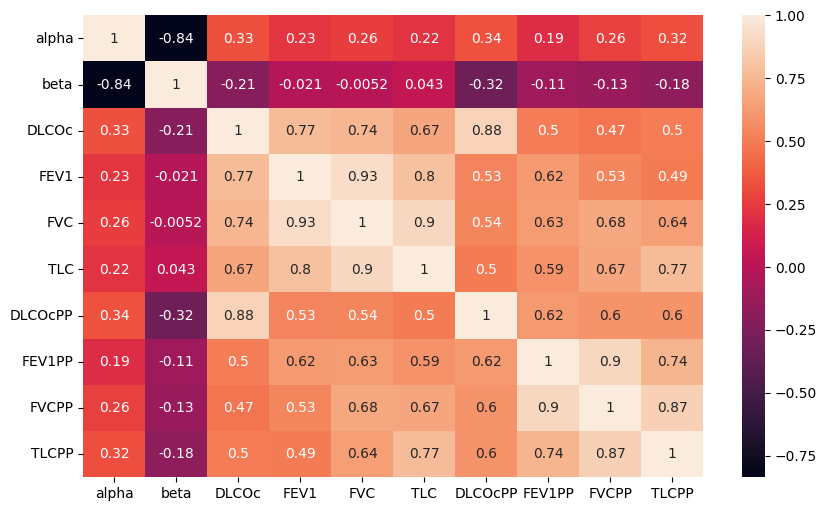

In [87]:
df_disease = pd.DataFrame(columns=['PatID', 'alpha','beta', 'DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])
i = 0
for idx, row in label_excel.iterrows():
    id_str = row['subjectID'].split('SSc_patient_')[-1][:7]
    if id_str not in ts_pat_ids:
        row_ab = alpha_beta_df[alpha_beta_df['pat_id']==int(id_str)]
        df_disease.loc[i] = [id_str, row_ab['alpha'].iloc[0], row_ab['beta'].iloc[0],  row['DLCOc_SB'], row['FEV1'], row['FVC'], row['TLC_He'], row['DLCOcPP'], row['FEV1PP'], row['FVCPP'], row['TLCPP']]
        i += 1
        
df_disease = clean_nan(df_disease)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_disease.corr(method='spearman'), ax=ax, annot=True)

# Zhiwei's original data

<AxesSubplot: >

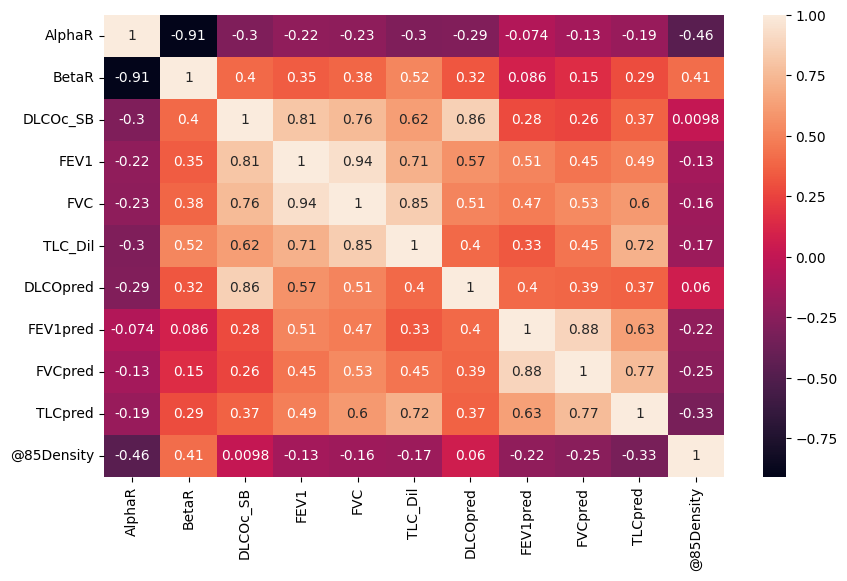

In [88]:
file = '/home/jjia/data/dataset/lung_function/patientData_merged.csv'
data77 = pd.read_csv(file)
data_avail = data77[['AlphaR', 'BetaR', 'DLCOc_SB', 'FEV1', 'FVC', 'TLC_Dil', 'DLCOpred', 'FEV1pred','FVCpred', 'TLCpred', '@85Density']]


fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(data_avail.corr(method='spearman'), ax=ax, annot=True)